# Tumor segmentation and visualization
Nanyan "Rosalie" Zhu & Chen "Raphael" Liu

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import transforms
from scipy.ndimage import rotate, filters
from skimage.measure import label, regionprops
import scipy.ndimage.morphology as ndi_morph
import skimage.morphology as skimage_morph
import seaborn as sns
import nibabel as nib
import os
from glob import glob

In [2]:
DRC_GBM_output_path = './Output/GBM/BySubject/'
DRC_WT_output_path = './Output/WT/BySubject/'
GBM_pathes = list(np.sort(glob(DRC_GBM_output_path + '*')))
WT_pathes = list(np.sort(glob(DRC_WT_output_path + '*')))

In [3]:
CBF_WH_files = []
CBV_WH_files = []
MTT_WH_files = []
WIR_WH_files = []
TTP_WH_files = []
#artery_label_WH_files = []

for path, folder, files in os.walk(DRC_GBM_output_path):
    for file in files:
        if ('CBF.' in file) and ('8e-08_sigma05' in path):
            if 'WH' == path.split('/')[-2]:
                CBF_WH_files.append(os.path.join(path, file))
        elif ('CBV.' in file) and ('8e-08_sigma05' in path):
            if 'WH' == path.split('/')[-2]:
                CBV_WH_files.append(os.path.join(path, file))
        elif ('MTT' in file) and ('8e-08_sigma05' in path):
            if 'WH' == path.split('/')[-2]:
                MTT_WH_files.append(os.path.join(path, file))
        elif ('WIR' in file) and ('8e-08_sigma05' in path):
            if 'WH' == path.split('/')[-2]:
                WIR_WH_files.append(os.path.join(path, file))
        elif ('TTP' in file) and ('8e-08_sigma05' in path):
            if 'WH' == path.split('/')[-2]:
                TTP_WH_files.append(os.path.join(path, file))
#        elif ('-label_1' in file) and ('8e-08_sigma05' in path):
 #           if 'WH' == path.split('/')[-2]:
  #              artery_label_WH_files.append(os.path.join(path, file))

In [209]:
CBF_WH_files = list(np.sort(CBF_WH_files))
CBV_WH_files = list(np.sort(CBV_WH_files))
MTT_WH_files = list(np.sort(MTT_WH_files))
WIR_WH_files = list(np.sort(WIR_WH_files))
TTP_WH_files = list(np.sort(TTP_WH_files))
#artery_label_WH_files = list(np.sort(artery_label_WH_files))

#print('TTP File Pathes:  ')
TTP_WH_files

['./Output/GBM/BySubject/Control1_Post10d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label_1.nii.gz',
 './Output/GBM/BySubject/Control1_Post14d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label_1.nii.gz',
 './Output/GBM/BySubject/Control2_Post10d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label_1.nii.gz',
 './Output/GBM/BySubject/Control2_Post14d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label_1.nii.gz',
 './Output/GBM/BySubject/Treatment1_Post10d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label_1.nii.gz',
 './Output/GBM/BySubject/Treatment1_Post14d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label_1.nii.gz',
 './Output/GBM/BySubject/Treatment1_Post20d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label_1.nii.gz',
 './Output/GBM/BySubject/Treatment2_Post10d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label_1.nii.gz',
 './Output/GBM/BySubject/Treatment2_Post14d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label_1.nii.gz',
 './Output/GBM/BySubject/Treatment2_Post20d/WH/pinv_tolerance_8e-08_sigma05/ADRC_CBV-label

## Functions

In [631]:
def subject_four_plots(subject, slice_idx, subplot_row, subplot_col, subplot_start_idx, title = False, Tumor_focus = False):
    
    # load CBV
    CBV_nii = np.squeeze(nib.load(CBV_WH_files[subject]).get_fdata()) * CBV_normalization_factor_list[subject] 
    # CBF
    CBF_nii = np.squeeze(nib.load(CBF_WH_files[subject]).get_fdata()) * CBF_normalization_factor_list[subject]
    # MTT
    # MTT_nii1 = np.squeeze(nib.load(MTT_WH_files[subject1]).get_fdata()) 
    MTT_nii = np.zeros(CBF_nii.shape)
    MTT_nii[(CBF_nii != 0)] = 60 * np.divide(CBV_nii[(CBF_nii != 0)], CBF_nii[(CBF_nii != 0)]) # in second
    # WIR
    WIR_nii = np.squeeze(nib.load(WIR_WH_files[subject]).get_fdata())
    # TTP
    TTP_nii = np.squeeze(nib.load(TTP_WH_files[subject]).get_fdata())
    

    plt.subplot(subplot_row, subplot_col, subplot_start_idx)
    rotated_CBV = CBV_nii[:, :, slice_idx]
    if title == True:
        plt.title('Cerebral Blood Volume (CBV)', Fontsize =  20)
    if Tumor_focus == True:
        plt.imshow(rotated_CBV, cmap = 'jet', clim = [0, 30])
    else:
        plt.imshow(rotated_CBV, cmap = 'jet', clim = [0, 8])
    plt.axis('off');

    plt.subplot(subplot_row, subplot_col, subplot_start_idx + 1)
    rotated_CBF = CBF_nii[:, :, slice_idx]
    if title == True:
        plt.title('Cerebral Blood Flow (CBF)', Fontsize =  20)
    if Tumor_focus == True:
        plt.imshow(rotated_CBF, cmap = 'jet', clim = [0, 2500])
    else:
        plt.imshow(rotated_CBF, cmap = 'jet', clim = [0, 700])
    plt.axis('off');

    plt.subplot(subplot_row, subplot_col, subplot_start_idx + 2)
    rotated_MTT = MTT_nii[:, :, slice_idx]
    if title == True:
        plt.title('Mean Transit Time (MTT)', Fontsize =  20)
    plt.imshow(rotated_MTT, cmap = 'jet', clim = [0, 1.5])
    plt.axis('off');

    plt.subplot(subplot_row, subplot_col, subplot_start_idx + 3)
    rotated_WIR = WIR_nii[:, :, slice_idx]
    if title == True:
        plt.title('Wash-in Rate (WIR)', Fontsize =  20)
    plt.imshow(rotated_WIR, cmap = 'jet', clim = [0, 0.3])
    plt.axis('off');


In [811]:
subjects_list = [path.split('/')[-4] for path in TTP_WH_files]
print('BAD SCANS: ', str(subjects_list[2]))
CBV_normalization_factor_list = [0.8, 1.35, 2, 12 / 11, 0.75, 0.8, 0.7, 0.95, 1, 0.8]
CBF_normalization_factor_list = [1.1, 1.45, 2, 10 / 8, 1.1, 0.7, 0.7, 0.95, 1, 0.8]

BAD SCANS:  Control2_Post10d


['Control1_Post10d',
 'Control1_Post14d',
 'Control2_Post10d',
 'Control2_Post14d',
 'Treatment1_Post10d',
 'Treatment1_Post14d',
 'Treatment1_Post20d',
 'Treatment2_Post10d',
 'Treatment2_Post14d',
 'Treatment2_Post20d']

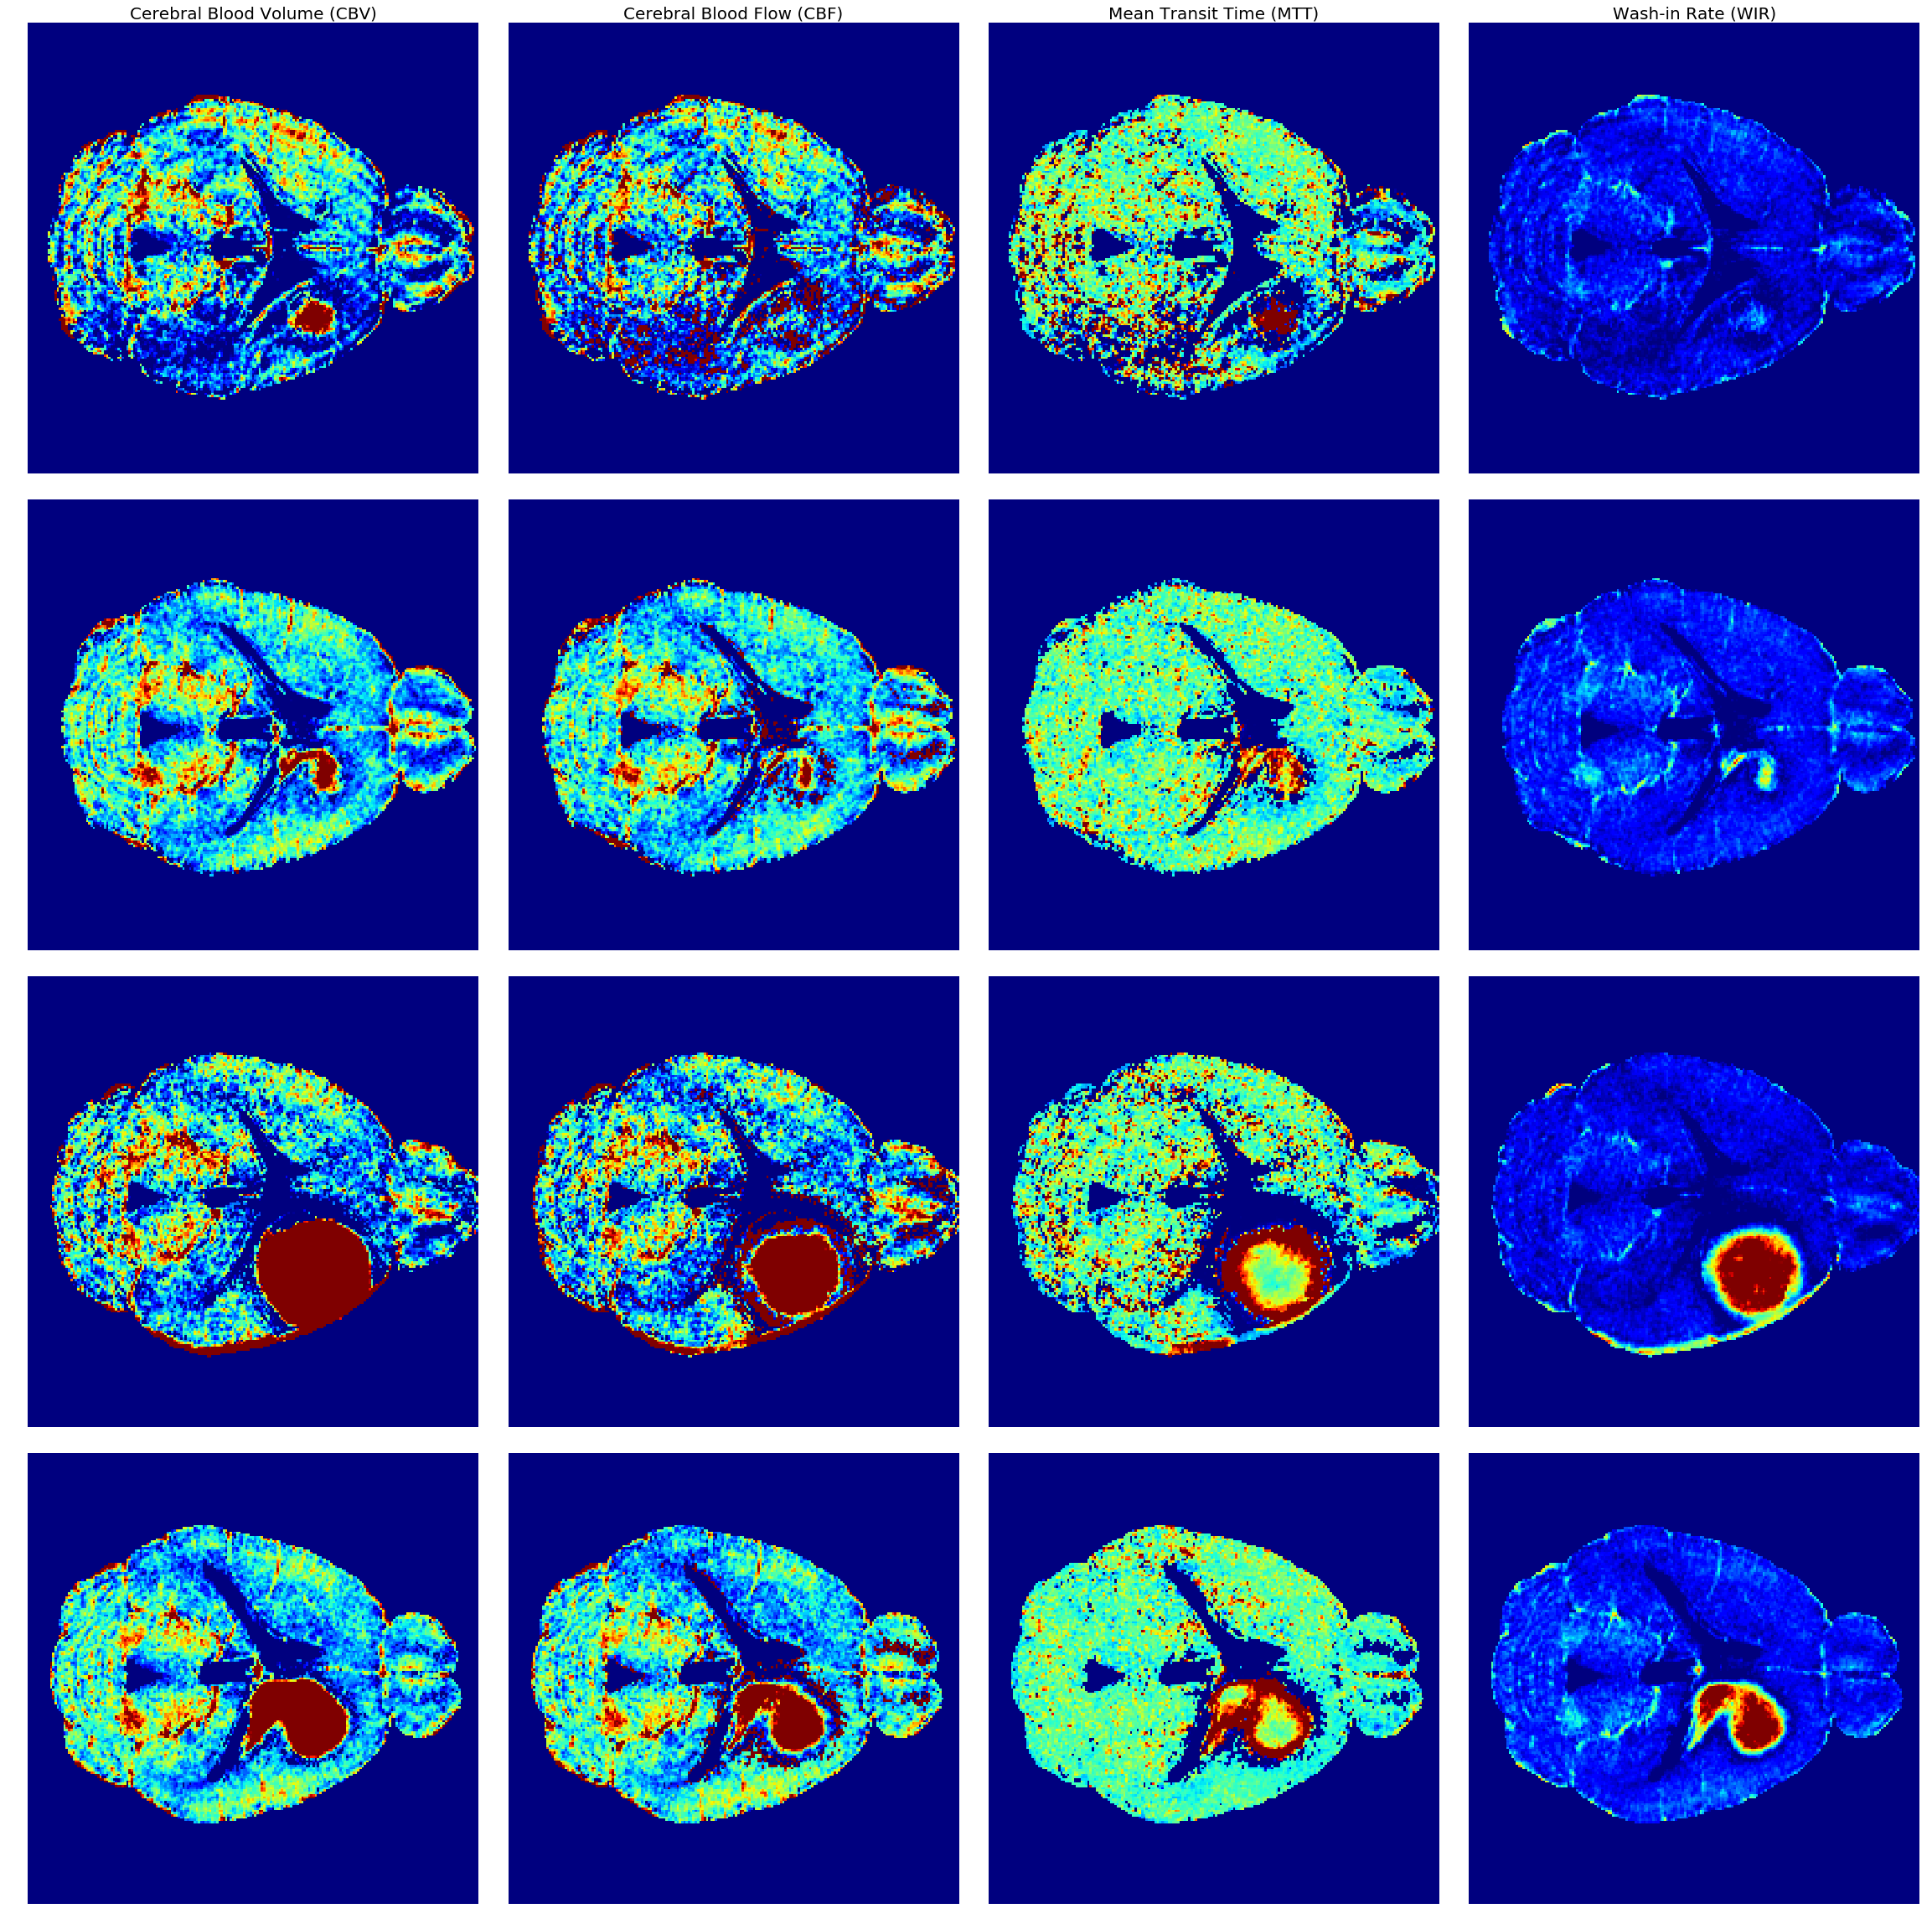

In [738]:
plt.rcParams['figure.figsize'] = [32, 32]

subject_four_plots(0 , 6, 4, 4, 1, title = True)
subject_four_plots(4 , 6, 4, 4, 5)
subject_four_plots(1 , 6, 4, 4, 9)
subject_four_plots(5 , 6, 4, 4, 13)

plt.tight_layout()
#plt.savefig('./Figures4SR/NonTumorRegion_focus_plots')

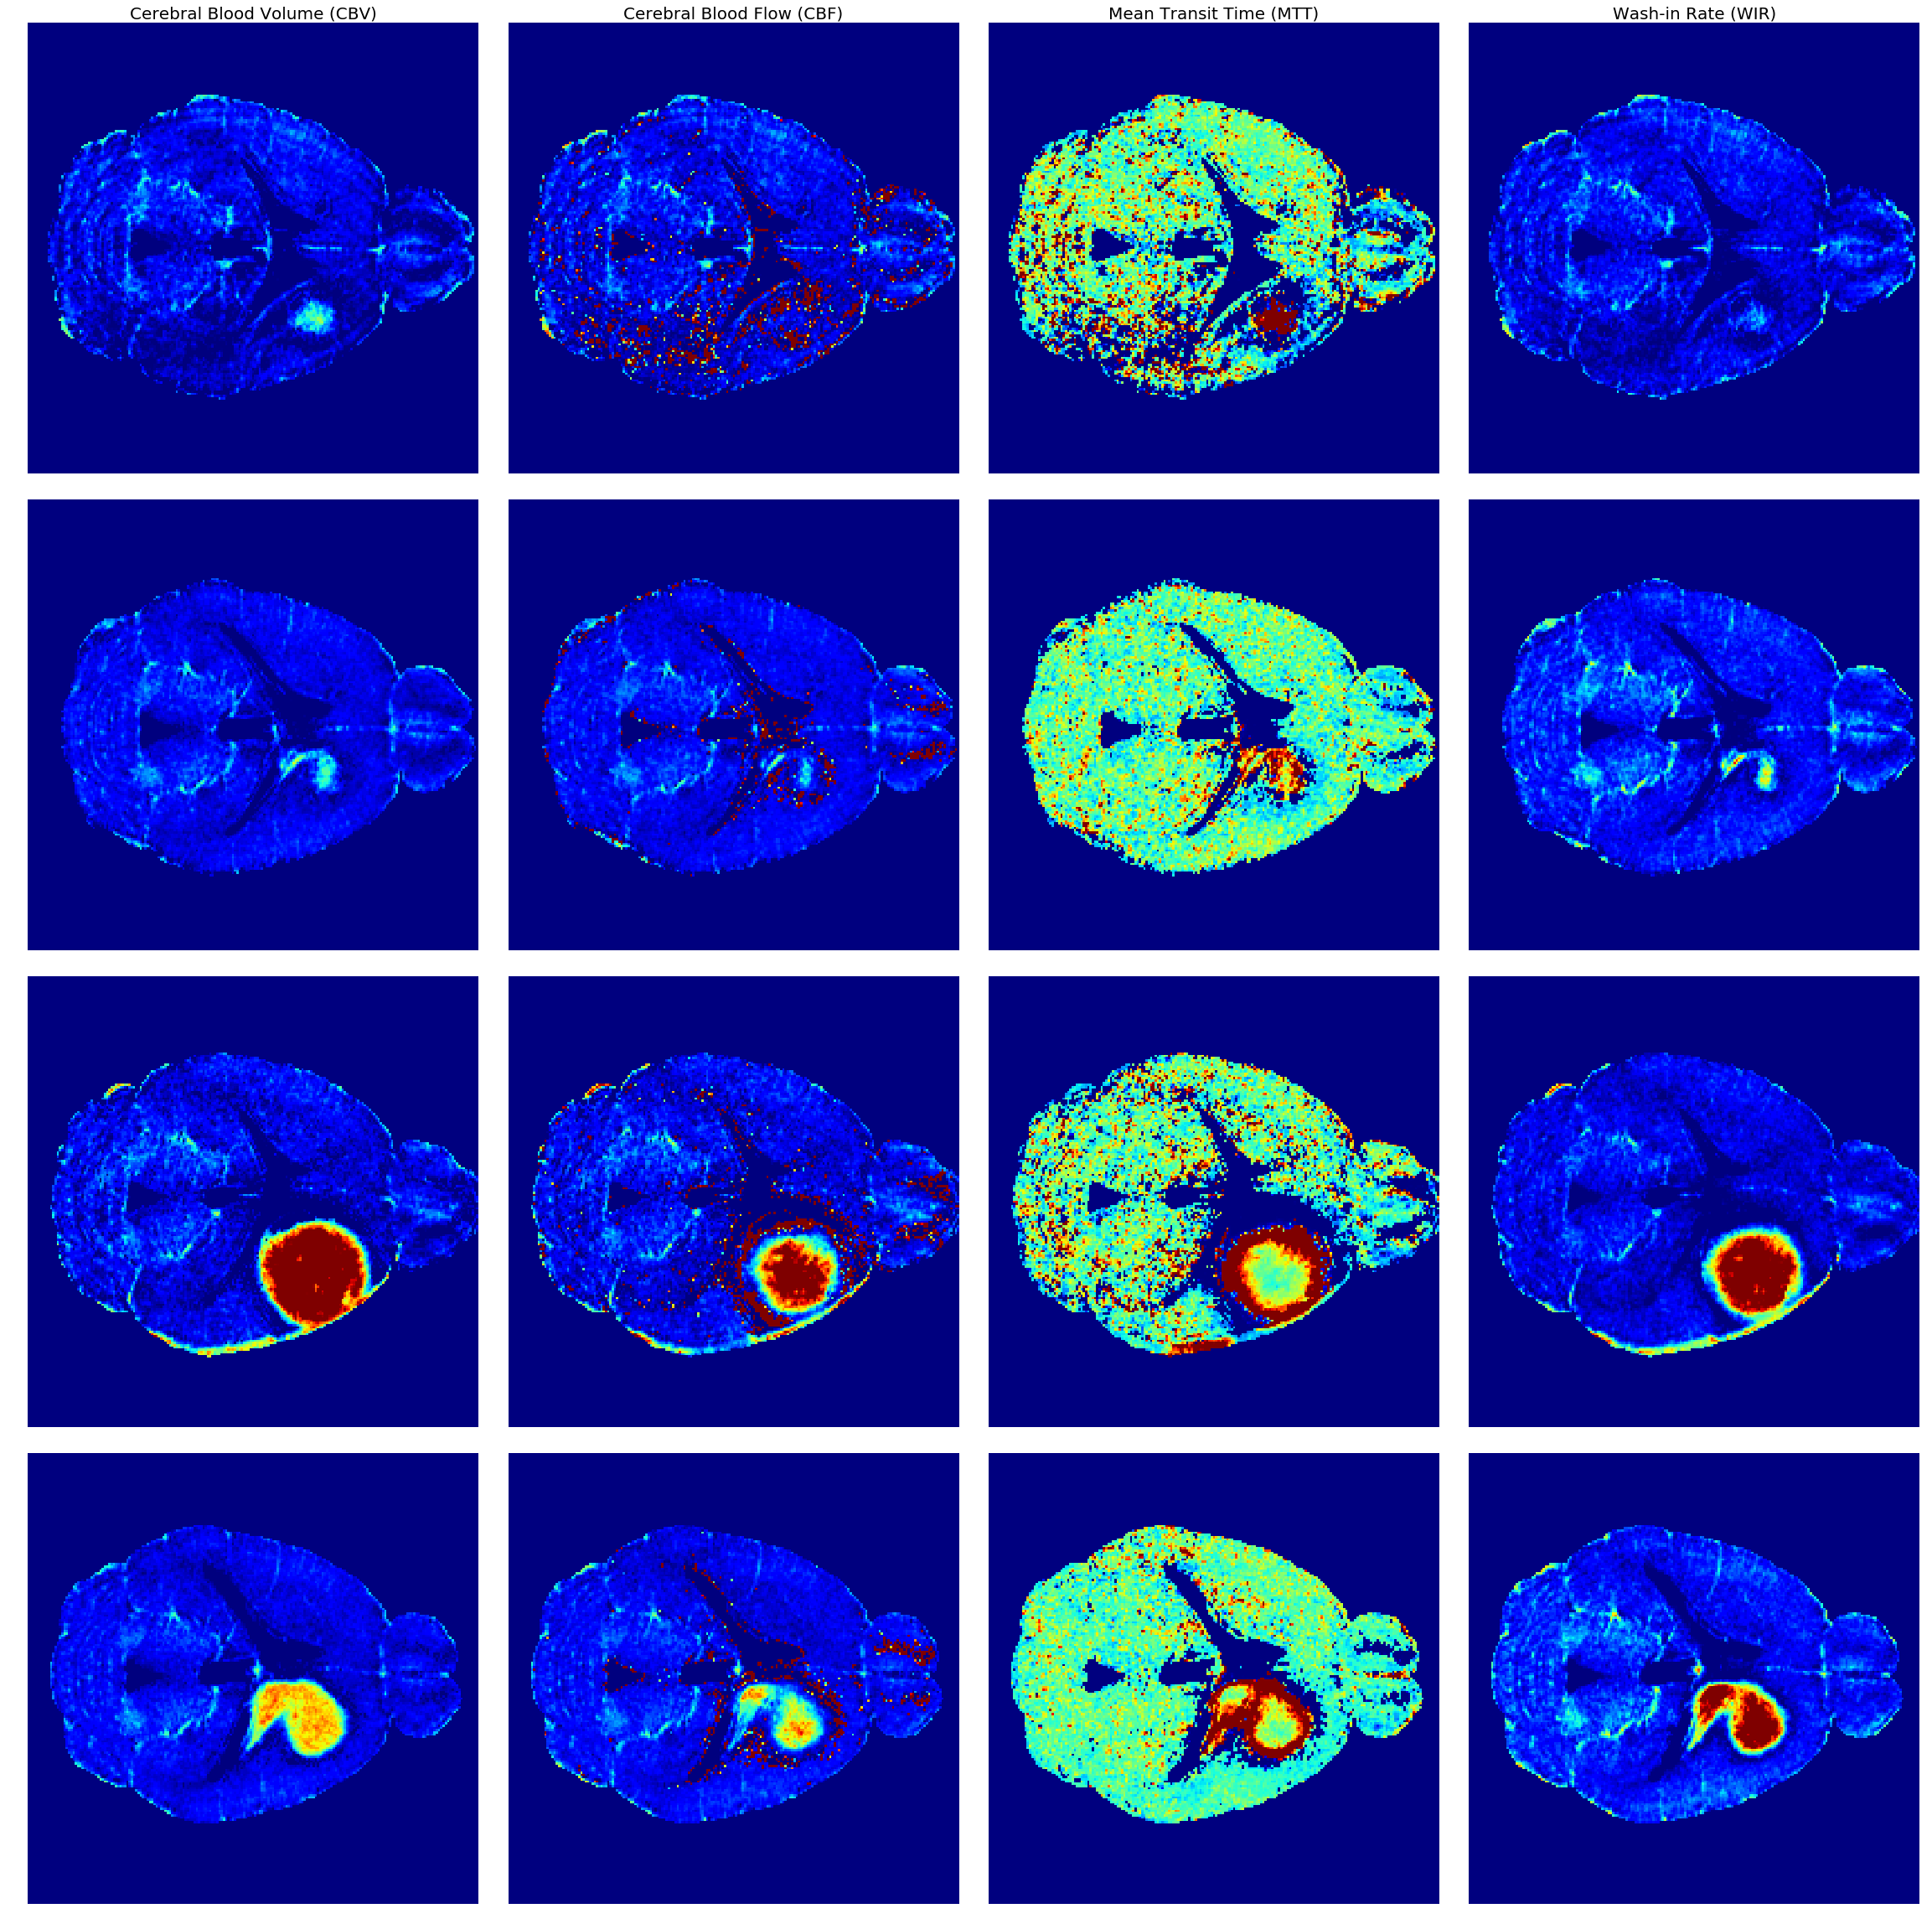

In [633]:
plt.rcParams['figure.figsize'] = [32, 32]

subject_four_plots(0 , 6, 4, 4, 1, title = True, Tumor_focus = True)
subject_four_plots(4 , 6, 4, 4, 5, Tumor_focus = True)
subject_four_plots(1 , 6, 4, 4, 9, Tumor_focus = True)
subject_four_plots(5 , 6, 4, 4, 13, Tumor_focus = True)

plt.tight_layout()
plt.savefig('./Figures4SR/Tumor_focus_plots')

### Update new normalized nifti files

In [813]:
for subject in range(len(CBV_WH_files)):
    CBV_file = CBV_WH_files[subject]
    path = '/'.join(CBV_file.split('/')[:-1])
    CBF_file = CBV_file.replace('_CBV.', '_CBF.')
    # load CBV
    CBV_nii = nib.load(CBV_file)
    CBV_new = np.squeeze(CBV_nii.get_fdata()) * CBV_normalization_factor_list[subject] 
    # CBF
    CBF_nii = np.squeeze(nib.load(CBF_file).get_fdata()) * CBF_normalization_factor_list[subject]
    # MTT
    MTT_nii = np.zeros(CBF_nii.shape)
    MTT_nii[(CBF_nii != 0)] = 60 * np.divide(CBV_new[(CBF_nii != 0)], CBF_nii[(CBF_nii != 0)]) # in second
    
    # save nifti files
    CBV_new_nii = nib.Nifti1Image(CBV_new, CBV_nii.affine, CBV_nii.header)
    CBF_new_nii = nib.Nifti1Image(CBF_nii, CBV_nii.affine, CBV_nii.header)
    MTT_new_nii = nib.Nifti1Image(MTT_nii, CBV_nii.affine, CBV_nii.header)
    
    nib.save(CBV_new_nii, path + '/Normalized_CBV.nii.gz')
    nib.save(CBF_new_nii, path + '/Normalized_CBF.nii.gz')
    nib.save(MTT_new_nii, path + '/Normalized_MTT.nii.gz')  

### Multivariable K-means to segment the tumor region

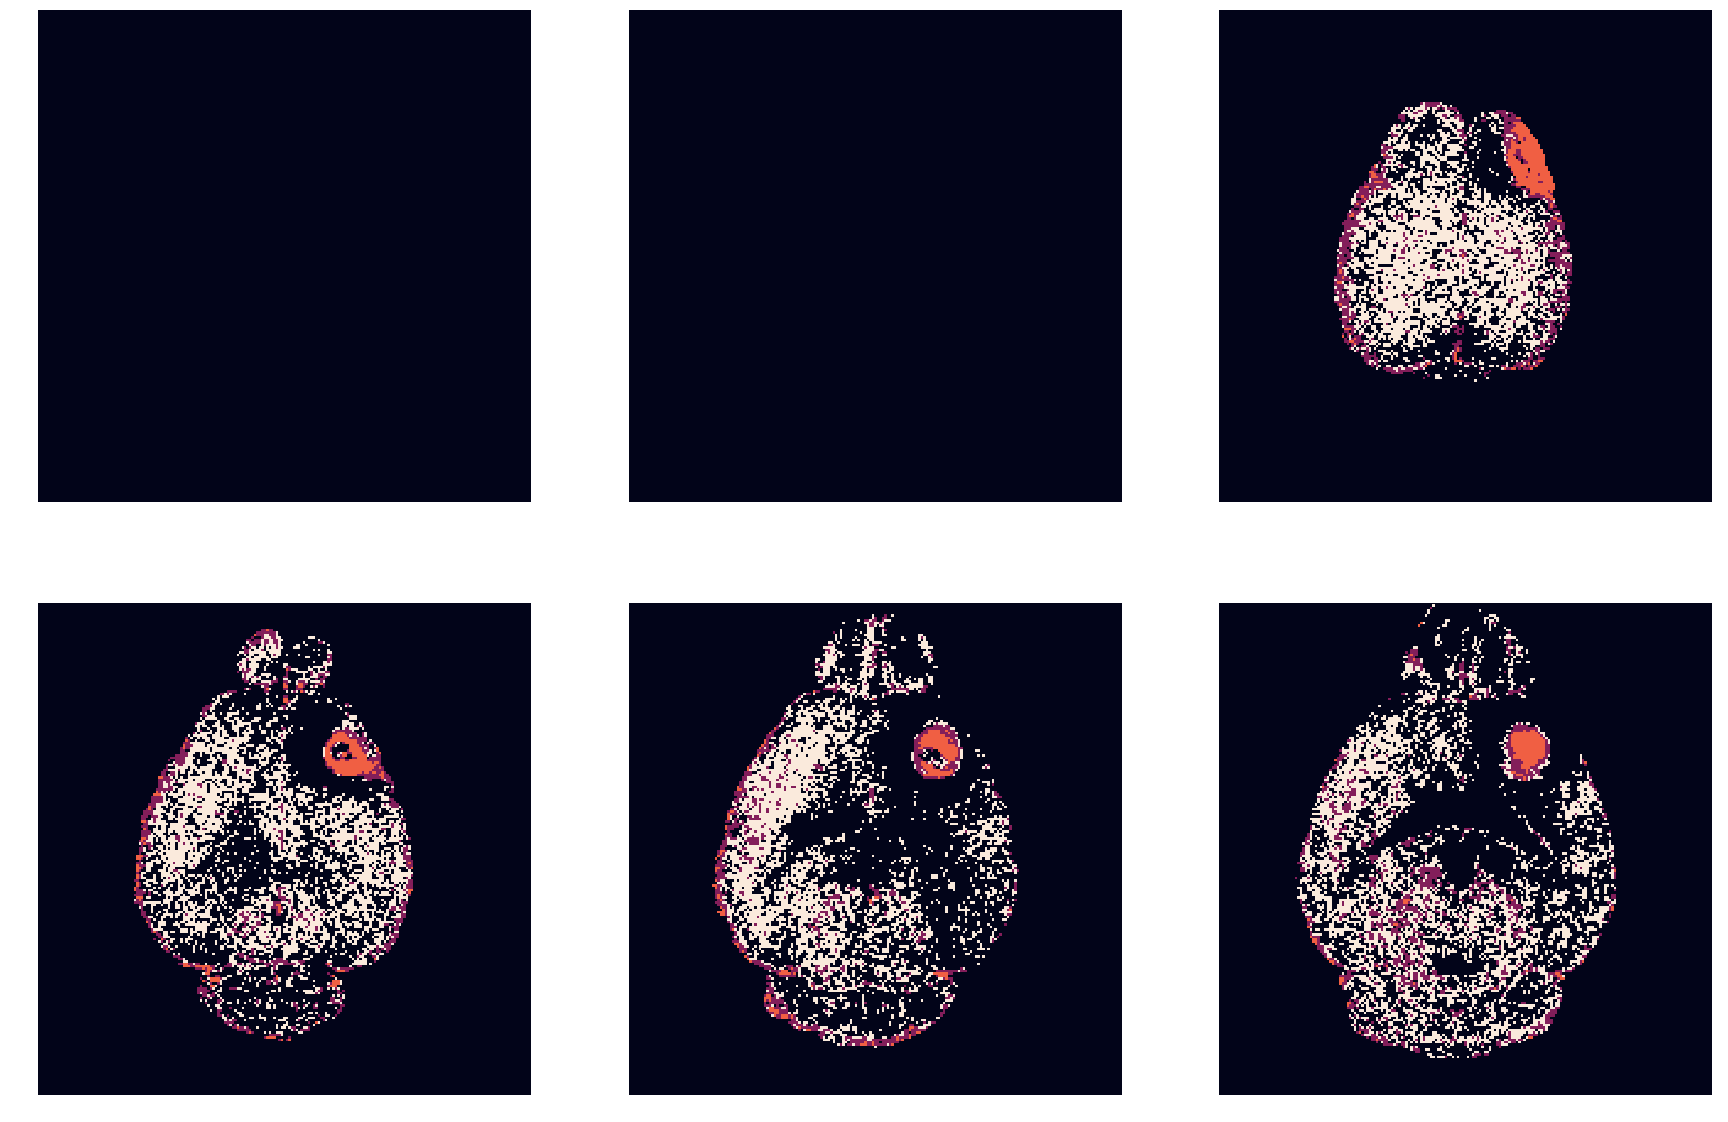

In [880]:
# Use CBV and WIR to do the clustering
subject = 2
# load CBV
CBV_nii = np.squeeze(nib.load(CBV_WH_files[subject].replace(CBV_WH_files[subject].split('/')[-1], 'Normalized_CBV.nii.gz')).get_fdata())
CBV_nii_clustering = CBV_nii.copy()
CBV_nii_clustering[:, :, 0:3] = 0
# WIR
WIR_nii = np.squeeze(nib.load(WIR_WH_files[subject]).get_fdata())
WIR_nii_clustering = WIR_nii.copy()
WIR_nii_clustering[:, :, 0:3] = 0

data = {'CBV_pixels': list(CBV_nii_clustering.flatten()), 'WIR_pixels': list(WIR_nii_clustering.flatten())}
cluster_df = pd.DataFrame(data)

# use kmeans clustering
clusters = 4
kmeans = KMeans(n_clusters = clusters)
kmeans.fit(cluster_df)

plt.rcParams['figure.figsize'] = [30, 20]
for idx in range(6):
    plt. subplot(2, 3, idx + 1)
    plt.imshow(rotate(np.array(kmeans.labels_).reshape((201, 201, 18))[:, :, 1 + idx], 90))
    plt.axis('off');

In [883]:
properties = regionprops(np.array(kmeans.labels_).reshape((201, 201, 18)))
properties.sort(key = lambda x: x.area)
smallest_two_properties = list(properties[0:2])
smallest_two_properties.sort(key = lambda x: x.extent)
coarse_tumor_label = np.array(kmeans.labels_).reshape((201, 201, 18)) == smallest_two_properties[0].label

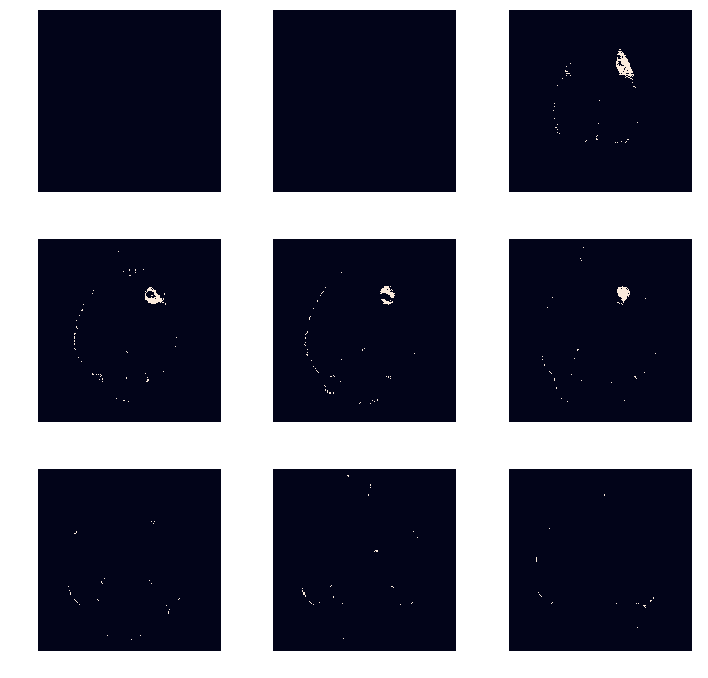

In [884]:
plt.rcParams['figure.figsize'] = [10, 10]
for idx in range(9):
    plt. subplot(3, 3, idx + 1)
    plt.imshow(rotate(coarse_tumor_label[:, :, 1 + idx], 90))
    plt.axis('off');
    plt.tight_layout()

In [885]:
tumor_label_map = label(coarse_tumor_label)
properties = regionprops(tumor_label_map)
properties.sort(key = lambda x: x.area, reverse = True)
biggest_two_properties = list(properties[0:2])
biggest_two_properties.sort(key = lambda x: x.major_axis_length / x.minor_axis_length)
for region_idx in range(len(properties)):
    if properties[region_idx].label != biggest_two_properties[0].label:
        tumor_label_map[tumor_label_map == properties[region_idx].label] = 0
        
fine_tumor_mask = tumor_label_map > 0

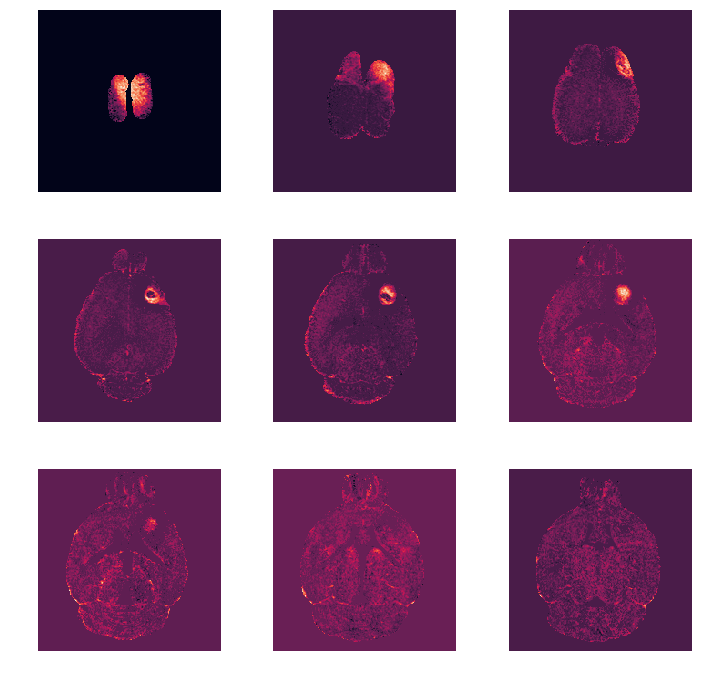

In [886]:
plt.rcParams['figure.figsize'] = [10, 10]
for idx in range(9):
    plt. subplot(3, 3, idx + 1)
    plt.imshow(rotate(CBV_nii[:, :, 1 + idx], 90))
    plt.axis('off');
    plt.tight_layout()

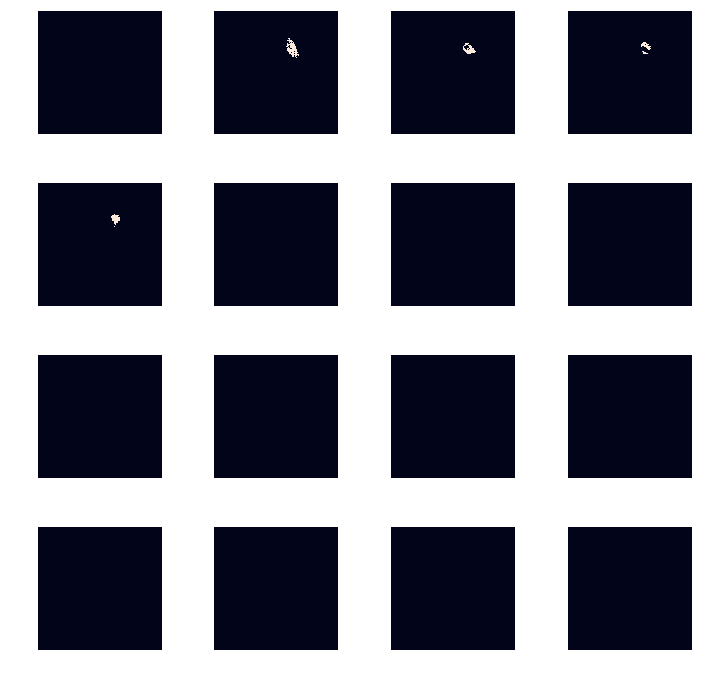

In [887]:
plt.rcParams['figure.figsize'] = [10, 10]
for idx in range(16):
    plt. subplot(4, 4, idx + 1)
    plt.imshow(rotate(fine_tumor_mask[:, :,  2 + idx], 90))
    plt.axis('off');
    plt.tight_layout()

In [888]:
# Image closing.
structure_element = skimage_morph.cube(7)
closed_tumor_mask = ndi_morph.binary_closing(fine_tumor_mask, structure = structure_element)

# Fill holes
filled_tumor_mask = ndi_morph.binary_fill_holes(closed_tumor_mask)

# dilation
structure_element = skimage_morph.ball(1)
dilated_tumor_mask = ndi_morph.binary_dilation(filled_tumor_mask, structure = structure_element)

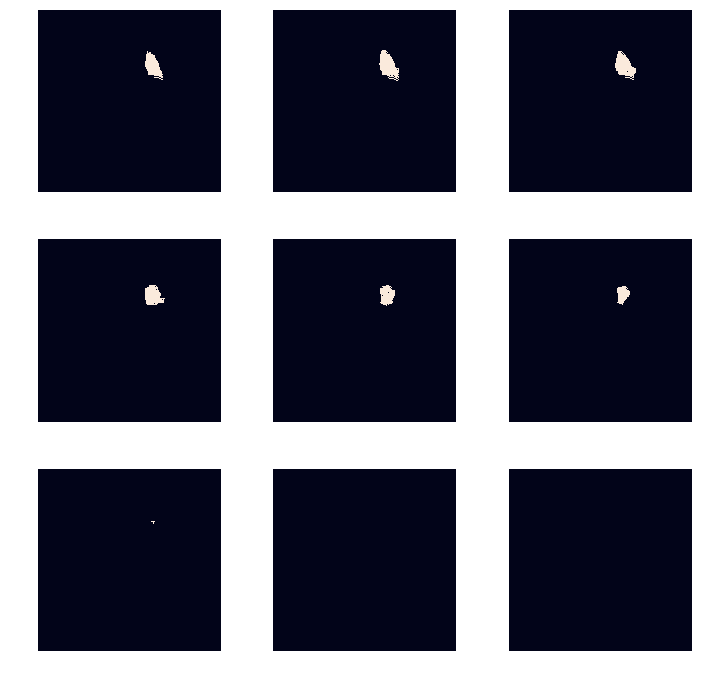

In [889]:
plt.rcParams['figure.figsize'] = [10, 10]
for idx in range(9):
    plt. subplot(3, 3, idx + 1)
    plt.imshow(rotate(dilated_tumor_mask[:, :, 2 + idx], 90))
    plt.axis('off');
    plt.tight_layout()

In [891]:
tumor_CBV = CBV_nii * dilated_tumor_mask
# save nifti
CBV_file = CBV_WH_files[subject]
nii_shell = nib.load(CBV_file)
path = '/'.join(CBV_file.split('/')[:-1])
tumor_mask_nii = nib.Nifti1Image(filled_tumor_mask, nii_shell.affine, nii_shell.header)
segmented_tumor_nii = nib.Nifti1Image(tumor_CBV, nii_shell.affine, nii_shell.header)

nib.save(tumor_mask_nii, path + '/Tumor_mask.nii.gz')
nib.save(segmented_tumor_nii, path + '/Segmented_tumor.nii.gz')

In [ ]:
plt.rcParams['figure.figsize'] = [20, 8]
for subject in range(10):
    CBV_file = CBV_WH_files[subject]
    path = '/'.join(CBV_file.split('/')[:-1])
    # load CBV
    CBV_nii = np.squeeze(nib.load(CBV_file.replace(CBV_WH_files[subject].split('/')[-1], 'Normalized_CBV.nii.gz')).get_fdata())
    CBV_nii_clustering = CBV_nii.copy()
    CBV_nii_clustering[:, :, 0:3] = 0
    # WIR
    WIR_nii = np.squeeze(nib.load(WIR_WH_files[subject]).get_fdata())
    WIR_nii_clustering = WIR_nii.copy()
    WIR_nii_clustering[:, :, 0:3] = 0

    data = {'CBV_pixels': list(CBV_nii_clustering.flatten()), 'WIR_pixels': list(WIR_nii_clustering.flatten())}
    cluster_df = pd.DataFrame(data)

    # use kmeans clustering
    clusters = 4
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(cluster_df)

    properties = regionprops(np.array(kmeans.labels_).reshape((201, 201, 18)))
    properties.sort(key = lambda x: x.area)
    coarse_tumor_label = np.array(kmeans.labels_).reshape((201, 201, 18)) == properties[0].label

    tumor_label_map = label(coarse_tumor_label)
    properties = regionprops(tumor_label_map)
    properties.sort(key = lambda x: x.area, reverse = True)
    biggest_two_properties = list(properties[0:2])
    biggest_two_properties.sort(key = lambda x: x.major_axis_length / x.minor_axis_length)
    for region_idx in range(len(properties)):
        if properties[region_idx].label != biggest_two_properties[0].label:
            tumor_label_map[tumor_label_map == properties[region_idx].label] = 0

    fine_tumor_mask = tumor_label_map > 0

    # Image closing.
    structure_element = skimage_morph.cube(7)
    closed_tumor_mask = ndi_morph.binary_closing(fine_tumor_mask, structure = structure_element)

    # dilation
    structure_element = skimage_morph.ball(1)
    dilated_tumor_mask = ndi_morph.binary_dilation(closed_tumor_mask, structure = structure_element)
    
    # Fill holes
    filled_tumor_mask = ndi_morph.binary_fill_holes(dilated_tumor_mask)

    tumor_CBV = CBV_nii * filled_tumor_mask
    
    # load nii shell
    nii_shell = nib.load(CBV_file)
    
    # save nifti
    tumor_mask_nii = nib.Nifti1Image(filled_tumor_mask, nii_shell.affine, nii_shell.header)
    segmented_tumor_nii = nib.Nifti1Image(tumor_CBV, nii_shell.affine, nii_shell.header)
    
    nib.save(tumor_mask_nii, path + '/Tumor_mask.nii.gz')
    nib.save(segmented_tumor_nii, path + '/Segmented_tumor.nii.gz')


### Tumor statistics

In [868]:
CBV_normalization_factor_list = [0.8, 1.35, 2, 1.3, 0.7, 0.7, 0.7, 0.9, 1, 0.8]
CBF_normalization_factor_list = [1.1, 1.45, 0.7, 1.1, 1.1, 0.7, 0.7, 0.8, 1, 0.8]
for subject in range(len(CBV_WH_files)):
    CBV_file = CBV_WH_files[subject]
    path = '/'.join(CBV_file.split('/')[:-1])
    CBF_file = CBV_file.replace('_CBV.', '_CBF.')
    # load CBV
    CBV_nii = nib.load(CBV_file)
    CBV_new = np.squeeze(CBV_nii.get_fdata()) * CBV_normalization_factor_list[subject] 
    # CBF
    CBF_nii = np.squeeze(nib.load(CBF_file).get_fdata()) * CBF_normalization_factor_list[subject]
    # MTT
    MTT_nii = np.zeros(CBF_nii.shape)
    MTT_nii[(CBF_nii != 0)] = 60 * np.divide(CBV_new[(CBF_nii != 0)], CBF_nii[(CBF_nii != 0)]) # in second
    
    # save nifti files
    CBV_new_nii = nib.Nifti1Image(CBV_new, CBV_nii.affine, CBV_nii.header)
    CBF_new_nii = nib.Nifti1Image(CBF_nii, CBV_nii.affine, CBV_nii.header)
    MTT_new_nii = nib.Nifti1Image(MTT_nii, CBV_nii.affine, CBV_nii.header)
    
    nib.save(CBV_new_nii, path + '/Normalized_CBV.nii.gz')
    nib.save(CBF_new_nii, path + '/Normalized_CBF.nii.gz')
    nib.save(MTT_new_nii, path + '/Normalized_MTT.nii.gz')  

In [869]:
size = []
mean_CBV = []
mean_CBF = []
mean_MTT = []
mean_WIR = []
for subject in range(10):
    CBV_file = CBV_WH_files[subject]
    path = '/'.join(CBV_file.split('/')[:-1])
    # load CBV
    CBV_nii = np.squeeze(nib.load(CBV_file.replace(CBV_WH_files[subject].split('/')[-1], 'Normalized_CBV.nii.gz')).get_fdata())
    
    # load CBF
    CBF_nii = np.squeeze(nib.load(CBV_file.replace(CBV_WH_files[subject].split('/')[-1], 'Normalized_CBF.nii.gz')).get_fdata())
    
    # load MTT
    MTT_nii = np.squeeze(nib.load(CBV_file.replace(CBV_WH_files[subject].split('/')[-1], 'Normalized_MTT.nii.gz')).get_fdata())
    
    # WIR
    WIR_nii = np.squeeze(nib.load(WIR_WH_files[subject]).get_fdata())
    
    # load Mask
    Tumor_mask = nib.load(CBV_file.replace(CBV_WH_files[subject].split('/')[-1], 'Tumor_mask.nii.gz')).get_fdata()
    
    se = skimage_morph.ball(1)
    eroded_mask = ndi_morph.binary_erosion(Tumor_mask, se)
    
    size.append(Tumor_mask.sum())
    mean_CBV.append(CBV_nii[Tumor_mask == 1].mean())
    mean_CBF.append(CBF_nii[eroded_mask == 1].mean())
    mean_MTT.append(MTT_nii[Tumor_mask == 1].mean())
    mean_WIR.append(WIR_nii[Tumor_mask == 1].mean())
   


In [876]:
size = np.delete(size, 6)
size = np.delete(size, 8)

In [870]:
normalized_mean_CBV = mean_CBV / np.mean(mean_CBV)
normalized_mean_CBV = np.delete(normalized_mean_CBV, 6)
normalized_mean_CBV = np.delete(normalized_mean_CBV, 8)
normalized_mean_CBF = mean_CBF / np.mean(mean_CBF)
normalized_mean_CBF = np.delete(normalized_mean_CBF, 6)
normalized_mean_CBF = np.delete(normalized_mean_CBF, 8)
normalized_mean_MTT = mean_MTT / np.mean(mean_MTT)
normalized_mean_MTT = np.delete(normalized_mean_MTT, 6)
normalized_mean_MTT = np.delete(normalized_mean_MTT, 8)
normalized_mean_WIR = mean_WIR / np.mean(mean_WIR)
normalized_mean_WIR = np.delete(normalized_mean_WIR, 6)
normalized_mean_WIR = np.delete(normalized_mean_WIR, )

In [897]:
data = {'Size': list(size * 0.00253125), 'Normalized Mean CBV' : list(normalized_mean_CBV), 'Normalized Mean CBF' : list(normalized_mean_CBF),\
        'Normalized Mean MTT' : list(normalized_mean_MTT), 'Normalized Mean WIR' : list(normalized_mean_WIR)}
ploting_subject_list = subjects_list.copy()
ploting_subject_list.remove(ploting_subject_list[6])
ploting_subject_list.remove(ploting_subject_list[8])
df = pd.DataFrame(data)

In [2]:
#pd.DataFrame.to_csv(df, 'data.csv')
df = pd.read_csv('data.csv')

In [3]:
df_10days = df.iloc[[0, 2, 4, 6], :]
df_14days = df.iloc[[1, 3, 5, 7], :]

In [4]:
control_10d = (df.iloc[0] + df.iloc[2])/ 2
treatment_10d = (df.iloc[4] + df.iloc[6])/ 2
control_14d = (df.iloc[1] + df.iloc[3])/ 2
treatment_14d = (df.iloc[5] + df.iloc[7])/ 2

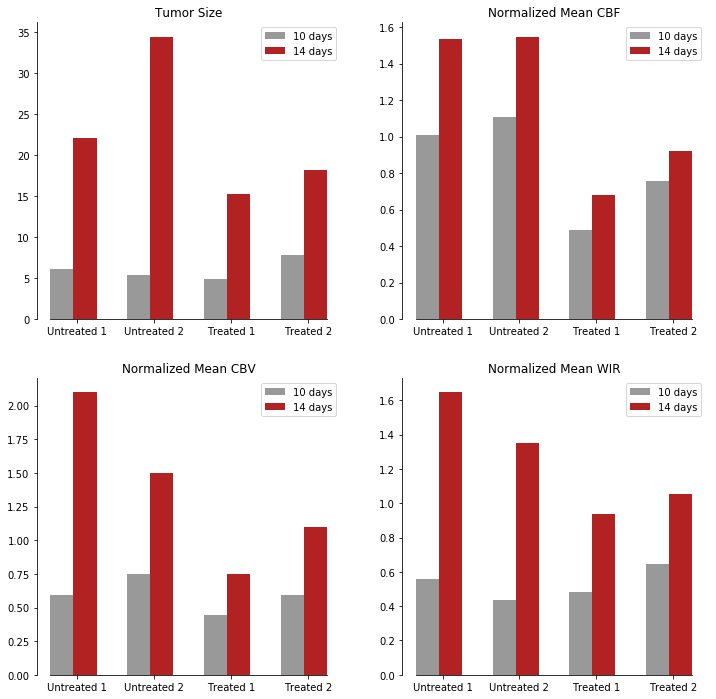

In [19]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
ind = np.array([1,2,3,4])
p1 = ax[0, 0].bar(ind, df_10days['Size'], width = 0.3, color='grey' , alpha = 0.8)
p2 = ax[0, 0].bar(ind + 0.3, df_14days['Size'], width = 0.3, color='firebrick')
ax[0, 0].set_title('Tumor Size') 
ax[0, 0].set_xticks(ind+0.2)
ax[0, 0].set_xticklabels(('Untreated 1','Untreated 2', 'Treated 1', 'Treated 2'))
ax[0, 0].legend((p1[0],p2[0]),('10 days','14 days'), loc = 'upper right')
ax[0, 0].spines['top'].set_color('none')
ax[0, 0].spines['right'].set_color('none')
ax[0, 0].spines['left'].set_smart_bounds(False)
ax[0, 0].spines['bottom'].set_smart_bounds(True)

p1 = ax[0, 1].bar(ind, df_10days['Normalized Mean CBF'], width = 0.3, color='grey' , alpha = 0.8)
p2 = ax[0, 1].bar(ind + 0.3, df_14days['Normalized Mean CBF'], width = 0.3, color='firebrick')
ax[0, 1].set_title('Normalized Mean CBF') 
ax[0, 1].set_xticks(ind+0.2)
ax[0, 1].set_xticklabels(('Untreated 1','Untreated 2', 'Treated 1', 'Treated 2'))
ax[0, 1].legend((p1[0],p2[0]),('10 days','14 days'), loc = 'upper right')
ax[0, 1].spines['top'].set_color('none')
ax[0, 1].spines['right'].set_color('none')
ax[0, 1].spines['left'].set_smart_bounds(False)
ax[0, 1].spines['bottom'].set_smart_bounds(True)

p1 = ax[1, 0].bar(ind, df_10days['Normalized Mean CBV'], width = 0.3, color='grey' , alpha = 0.8)
p2 = ax[1, 0].bar(ind + 0.3, df_14days['Normalized Mean CBV'], width = 0.3, color='firebrick')
ax[1, 0].set_title('Normalized Mean CBV') 
ax[1, 0].set_xticks(ind+0.2)
ax[1, 0].set_xticklabels(('Untreated 1','Untreated 2', 'Treated 1', 'Treated 2'))
ax[1, 0].legend((p1[0],p2[0]),('10 days','14 days'), loc = 'upper right')
ax[1, 0].spines['top'].set_color('none')
ax[1, 0].spines['right'].set_color('none')
ax[1, 0].spines['left'].set_smart_bounds(False)
ax[1, 0].spines['bottom'].set_smart_bounds(True)

p1 = ax[1, 1].bar(ind, df_10days['Normalized Mean WIR'], width = 0.3, color='grey' , alpha = 0.8)
p2 = ax[1, 1].bar(ind + 0.3, df_14days['Normalized Mean WIR'], width = 0.3, color='firebrick')
ax[1, 1].set_title('Normalized Mean WIR') 
ax[1, 1].set_xticks(ind+0.2)
ax[1, 1].set_xticklabels(('Untreated 1','Untreated 2', 'Treated 1', 'Treated 2'))
ax[1, 1].legend((p1[0],p2[0]),('10 days','14 days'), loc = 'upper right')
ax[1, 1].spines['top'].set_color('none')
ax[1, 1].spines['right'].set_color('none')
ax[1, 1].spines['left'].set_smart_bounds(False)
ax[1, 1].spines['bottom'].set_smart_bounds(True)

plt.savefig('./Figures4SR/Statistics.png')
